## 分析目标

1. 数据的时间跨度，不同时间段热门视频数目变化
2. views,like,dislike,conment_count前十的标题,所属类别以及具体数值
3. 一个视频可能会反复登上热门，views,likes,dislikes,comment_count这四个数值往往同步变化，这四个数值之间的相关性分析
4. title的长度分布，分析热词
5. 每个类别的热门视频数目，排序
6. 按照所发布上热门视频总次数最具影响力up主，频道与视频数分布情况
7. 每个视频的热门天数分布，不同类别的持续热门时间有没有不同
8. dislike/like比值定义为争议值，不同类别的争议值是否不同？comment_count/views定义为表达值，不同类别的表达值是否不同？
9. 如果我的视频想上热门，最好的发布时间是星期几，是几点钟？不同类别有不同吗？

In [1]:
#数据准备，读取数据，为每个视频的category_id匹配上category，并检测填充缺失值

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import wordcloud

In [3]:
df_us = pd.read_csv(r"Z:\youtube data\USvideos.csv")

In [4]:
df_cat_id = pd.read_json(r"Z:\youtube data\US_category_id.json")

In [5]:
def func1(dict):
    return int(dict.get("id"))
def func2(dict):
    return dict.get("snippet").get("title")

In [6]:
df_cat_id = df_cat_id["items"].apply([func1,func2])

In [7]:
data_us = pd.merge(df_us,df_cat_id,how="left",left_on="category_id",right_on="func1").drop(columns="func1").rename(columns={"func2":"category"})

In [8]:
data_us.isnull().any()

video_id                  False
trending_date             False
title                     False
channel_title             False
category_id               False
publish_time              False
tags                      False
views                     False
likes                     False
dislikes                  False
comment_count             False
thumbnail_link            False
comments_disabled         False
ratings_disabled          False
video_error_or_removed    False
description                True
category                  False
dtype: bool

In [9]:
data_us.fillna("",inplace=True)

In [10]:
#数据的时间跨度  trending_date列字符串格式，年.日.月格式修正为年月日

In [11]:
temp = data_us["trending_date"]
data_us["trending_date"] = temp.str.split(".").str[0] + temp.str.split(".").str[2] + temp.str.split(".").str[1]

In [12]:
data_us["trending_date"].aggregate(["min","max"])

min    171114
max    180614
Name: trending_date, dtype: object

#### 时间跨度为2017年11月14日到2018年6月14日

In [13]:
data_us["trending_year_month"] = data_us["trending_date"].str[:2] + "-" + data_us["trending_date"].str[2:4] 

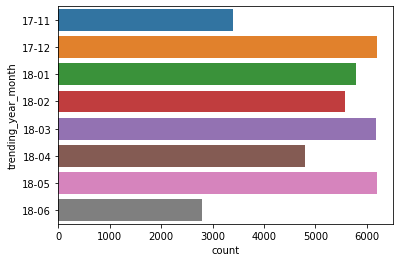

In [14]:
_=sns.countplot(y="trending_year_month",data=data_us)

#### 不同月份热门视频数

views,like,dislike,conment_count前十的标题,所属类别以及具体数值(因为标题出现乱码报出警告，用video_id代替标题）

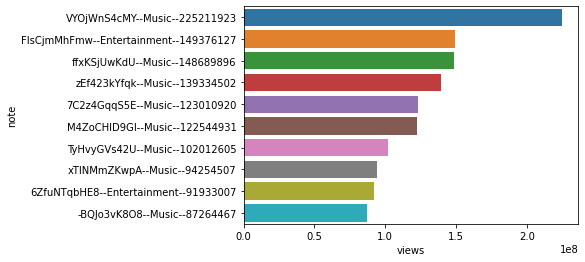

In [15]:
temp = data_us.loc[:,["views","title","category","video_id"]].sort_values(by="views",ascending=False).drop_duplicates(subset=["video_id"],keep="first").iloc[:10,:]
temp["note"] = temp["video_id"] + "--" + temp["category"] + "--" + temp["views"].apply(str)
_=sns.barplot(y="note",x="views",data=temp)

#### 前10观看数的热门视频，其中8个音乐类，2个娱乐类，观看最多的热门视频为音乐类，观看人数达到2.2亿

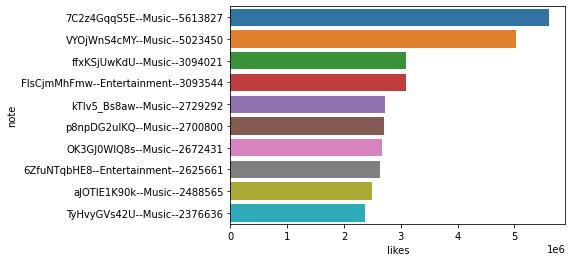

In [16]:
temp = data_us.loc[:,["likes","title","category","video_id"]].sort_values(by="likes",ascending=False).drop_duplicates(subset=["video_id"],keep="first").iloc[:10,:]
temp["note"] = temp["video_id"] + "--" + temp["category"] + "--" + temp["likes"].apply(str)
_=sns.barplot(y="note",x="likes",data=temp)

#### 前10点赞数的热门视频，其中8个音乐类，2个娱乐类，点赞最多的热门视频为音乐类，560万观众为此点赞，点赞榜第一名并不是观看榜第一名

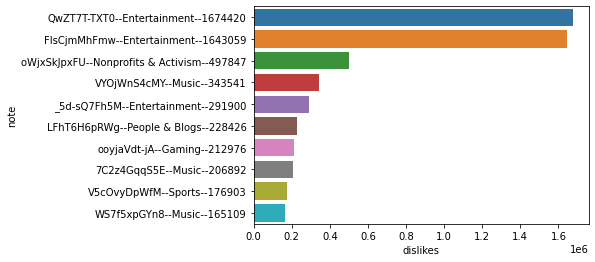

In [17]:
temp = data_us.loc[:,["dislikes","title","category","video_id"]].sort_values(by="dislikes",ascending=False).drop_duplicates(subset=["video_id"],keep="first").iloc[:10,:]
temp["note"] = temp["video_id"] + "--" + temp["category"] + "--" + temp["dislikes"].apply(str)
_=sns.barplot(y="note",x="dislikes",data=temp)

#### 最多有167万观众按下了倒赞，第一第二名包揽了前十的绝大部分倒赞

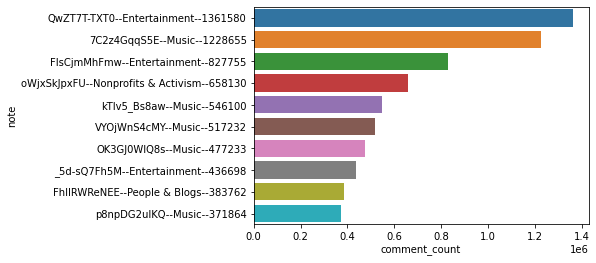

In [18]:
temp = data_us.loc[:,["comment_count","title","category","video_id"]].sort_values(by="comment_count",ascending=False).drop_duplicates(subset=["video_id"],keep="first").iloc[:10,:]
temp["note"] = temp["video_id"] + "--" + temp["category"] + "--" + temp["comment_count"].apply(str)
_=sns.barplot(y="note",x="comment_count",data=temp)

#### 最多有136万观众对视频发表了看法，评论数前十来自于音乐类和娱乐类

### views,likes,dislikes,comment_count这四个数值之间的相关性分析

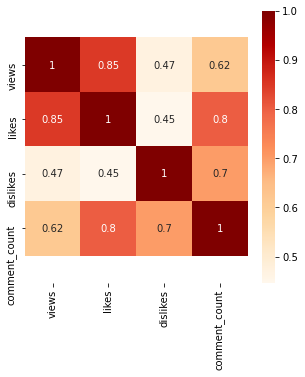

In [19]:
fig, ax = plt.subplots(figsize=(5,5)) 
ax = sns.heatmap(data_us.iloc[:,[7,8,9,10]].corr(), annot=True, cbar=True,ax=ax,cmap="OrRd")
bottom, top = ax.get_ylim()
_ = ax.set_ylim(bottom + 0.5, top - 0.5)

#### 最大的相关度为0.85，为likes 和 views，暂且只对这两个变量进行描点并拟合

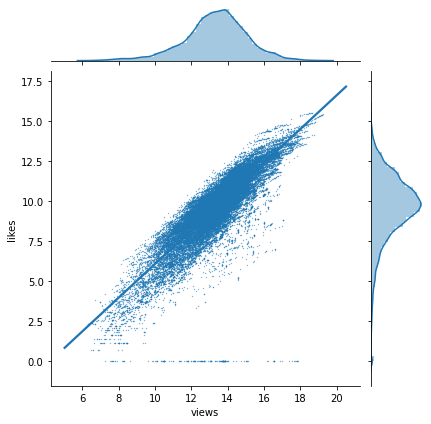

In [20]:
_=sns.jointplot(x = np.log(data_us["views"]+1), y = np.log(data_us["likes"]+1),kind="reg",scatter_kws={'s':0.1})

#### 对视频的观看数和点赞数取对数后，发现二者都呈正态分布，而且能用直线拟合

### title的长度分布，分析热词

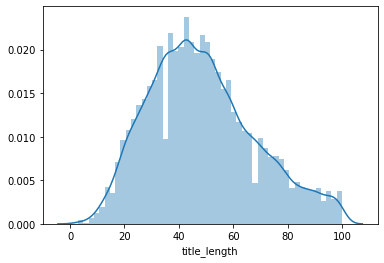

In [21]:
data_us["title_length"] = data_us["title"].str.len()
_ = sns.distplot(data_us["title_length"])

#### 热门视频标题长度分布，大致符合正态分布

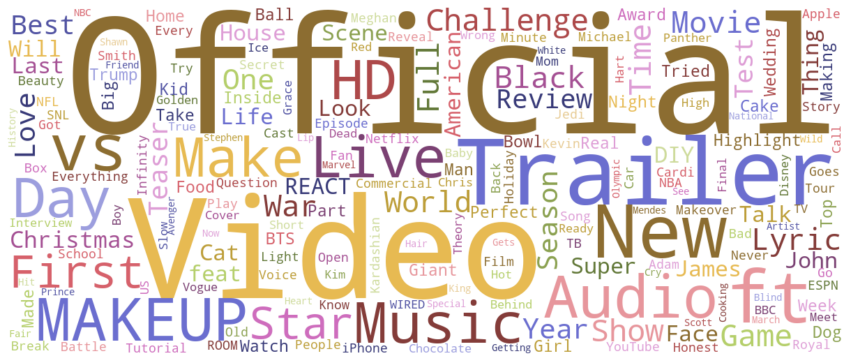

In [22]:
title_words = list(data_us["title"].apply(lambda x: x.split(" ")))
title_words = [x for y in title_words for x in y]
wc = wordcloud.WordCloud(width=1200, height=500, collocations=False, background_color="white", colormap="tab20b").generate(" ".join(title_words))
plt.figure(figsize=(15,10))
plt.imshow(wc, interpolation='bilinear')
_ = plt.axis("off")

#### 热门视频标题中热词词云如上图所示，常见词为Video, Trailer, Official等等

### 每个类别的视频上热门次数

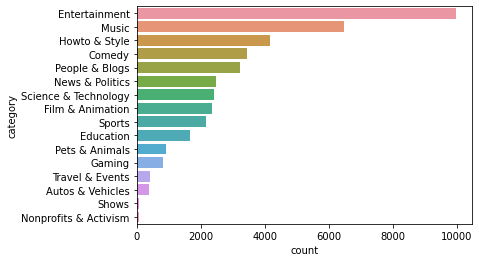

In [23]:
_=sns.countplot(y="category",data=data_us,order = data_us["category"].value_counts().index)

#### 娱乐类一马当先，紧随其后的是音乐类

### 按照所发布上热门视频总次数最具影响力up主，是否具有头部效应？

In [24]:
data_us["channel"] = data_us["channel_title"] + "--" + data_us["category"]

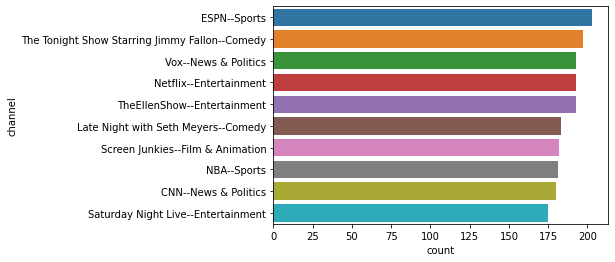

In [25]:
_ = sns.countplot(y = "channel",data=data_us,order=data_us["channel"].value_counts().iloc[:10].index)

#### 热门次数前十的up主要来自于体育，娱乐和时政，头部频道上热门次数差距不大

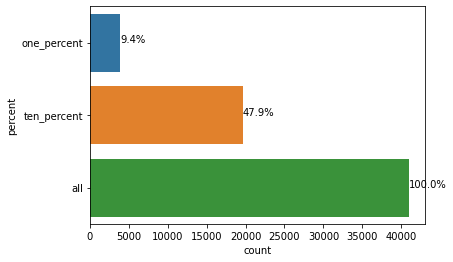

In [26]:
temp = data_us["channel_title"].value_counts()
count = temp.shape[0]
temp_one_percent = temp.iloc[:count//100].sum()
temp_ten_percent = temp.iloc[:count//10].sum()
temp_all = temp.sum()
df_temp = pd.DataFrame([["one_percent",temp_one_percent],["ten_percent",temp_ten_percent],["all",temp_all]],columns=["percent","count"])
ax = sns.barplot(y="percent",x="count",data=df_temp)
total = temp_all
for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))

#### 排行前百分之一的频道贡献了百分之十的热门视频，前百分之十的频道贡献了接近一半的热门视频

### 每个视频的热门天数分布，不同类别的持续热门时间有没有不同

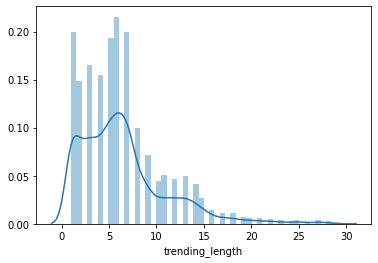

In [27]:
temp= data_us.groupby("video_id")["trending_date"].unique().str.len() 
temp = temp.to_frame().reset_index().rename(columns={"trending_date":"trending_length"})
temp = pd.merge(left=temp,right=data_us.drop_duplicates(["video_id"]).loc[:,["video_id","category"]],how ="left", left_on="video_id",right_on="video_id")
_=sns.distplot(temp["trending_length"])

#### 大部分视频的热门天数集中在7天以及7天之前

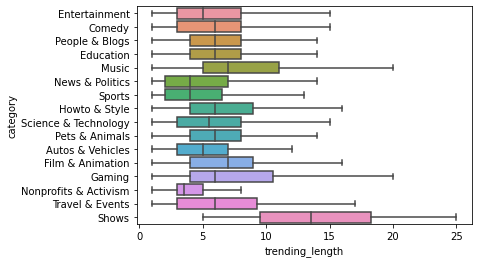

In [28]:
_ = sns.boxplot(x="trending_length",y="category",data=temp,showfliers=False)

#### 时事政治相关视频的流行天数最少，而show相关视频流行天数最长，中位数为13天

### 不同类别的dislike/like是否不同？不同类别的comment_count/views比值是否不同？

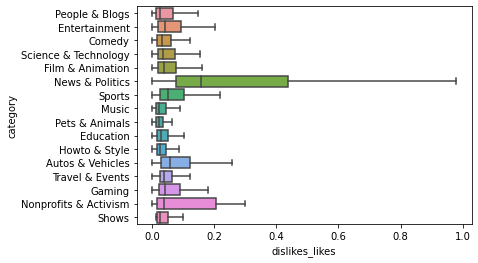

In [29]:
data_us.eval("dislikes_likes = dislikes / likes",inplace=True)
_=sns.boxplot(x="dislikes_likes",y="category",data=data_us,showfliers=False)

#### 在时事政治板块，争议值的中位数更大，人们更容易点倒赞。

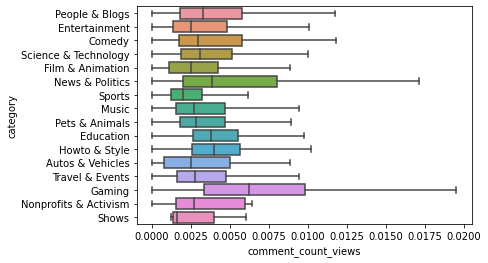

In [30]:
data_us.eval("comment_count_views = comment_count / views",inplace=True)
_=sns.boxplot(x="comment_count_views",y="category",data=data_us,showfliers=False)

#### 在游戏板块，观众更喜欢发表评论

### 如果我的视频想上热门，最好的发布时间是星期几，是几点钟？不同类别有不同吗？

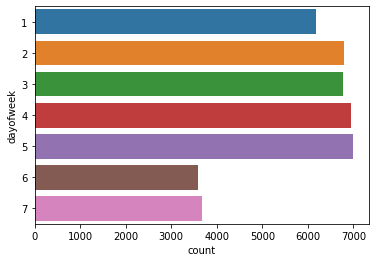

In [31]:
data_us["publish_time"] = pd.to_datetime(data_us["publish_time"])
data_us["dayofweek"] = data_us["publish_time"].dt.dayofweek + 1  #原来0是星期一，加上1使1代表星期一
_ = sns.countplot(y="dayofweek",data=data_us,order=[1,2,3,4,5,6,7])

#### 可以很明显看到流行视频中发布日期在周六周日的几乎只有工作日的一半

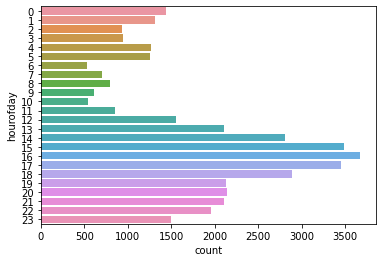

In [32]:
data_us["hourofday"] = data_us["publish_time"].dt.hour
_ = sns.countplot(y="hourofday",data=data_us,order=range(24))

#### 热门视频的发布时间主要集中在下午1点到晚上10点

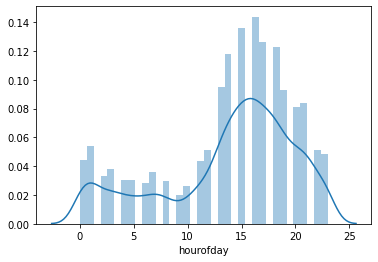

In [33]:
_=sns.distplot(data_us.loc[data_us["category"]=="Entertainment","hourofday"])

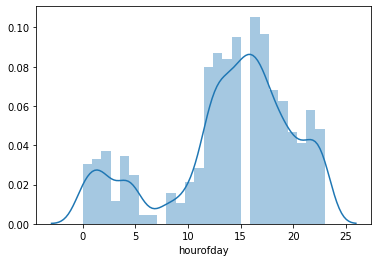

In [34]:
_=sns.distplot(data_us.loc[data_us["category"]=="News & Politics","hourofday"])

#### 每个类别热门视频的每个星期的发布时间和每天的发布时间都差不多，暂时只展示了最多的两类，娱乐板块和时政板块
#### 最适合的发布时间是工作日下午一点到晚上10点

### 谢谢观看